# 📧 **Phishing Email Detection - Modelado Completo**

## 🎯 **Objetivo**
Entrenar y evaluar múltiples modelos de Machine Learning para clasificación de emails phishing vs legítimos.

## 📋 **Modelos Incluidos**
1. Logistic Regression
2. Random Forest
3. SVM (Support Vector Machine)
4. Gradient Boosting

## 📊 **Dataset**
- **Train**: 31,323 emails (80%)
- **Test**: 7,831 emails (20%)
- **Clases**: 0=Legítimo (44.22%), 1=Phishing (55.78%)

---

## 📦 **FASE 0: Configuración Inicial**

In [1]:
# Importaciones
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Configurar rutas
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from datetime import datetime

# Importar módulos del proyecto
from features.feature_engineering import engineer_features, save_features_and_vectorizer, load_vectorizer
from models.train import train_models, select_best_model, save_results

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Librerías importadas exitosamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

✅ Librerías importadas exitosamente
📅 Fecha de ejecución: 2026-01-10 14:39:53


## ⚙️ **Cargar Configuración**

In [2]:
# Cargar configuración desde YAML
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("📋 Configuración cargada:")
print(f"   Proyecto: {config['project']['name']} v{config['project']['version']}")
print(f"   Dataset: {config['data']['train_samples']} train, {config['data']['test_samples']} test")
print(f"   TF-IDF max features: {config['features']['tfidf']['max_features']}")
print(f"   Random state: {config['models']['random_state']}")
print(f"   Métrica principal: {config['evaluation']['primary_metric']}")

📋 Configuración cargada:
   Proyecto: phishing_detection_local v1.0.0
   Dataset: 31323 train, 7831 test
   TF-IDF max features: 1000
   Random state: 42
   Métrica principal: f1_score


---
## 📂 **FASE 1: Carga de Datos**

In [3]:
# Rutas a los datos
data_dir = '../../processed_data'
train_path = os.path.join(data_dir, config['data']['train_file'])
test_path = os.path.join(data_dir, config['data']['test_file'])

print("🔄 Cargando datasets...")
print(f"   Train: {train_path}")
print(f"   Test: {test_path}")

# Cargar datos
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"\n✅ Datos cargados:")
print(f"   Train: {train_df.shape[0]:,} registros x {train_df.shape[1]} columnas")
print(f"   Test: {test_df.shape[0]:,} registros x {test_df.shape[1]} columnas")

# Verificar distribución de clases
print(f"\n📊 Distribución de clases (Train):")
train_class_dist = train_df['label'].value_counts().sort_index()
for label in [0, 1]:
    count = train_class_dist[label]
    pct = (count / len(train_df)) * 100
    label_name = "Legítimo" if label == 0 else "Phishing"
    print(f"   Clase {label} ({label_name}): {count:,} ({pct:.2f}%)")

🔄 Cargando datasets...
   Train: ../../processed_data/train.csv
   Test: ../../processed_data/test.csv

✅ Datos cargados:
   Train: 31,323 registros x 7 columnas
   Test: 7,831 registros x 7 columnas

📊 Distribución de clases (Train):
   Clase 0 (Legítimo): 13,850 (44.22%)
   Clase 1 (Phishing): 17,473 (55.78%)


In [4]:
# Mostrar primeras filas
print("🔎 Primeras filas del dataset (Train):")
display(train_df.head())

print("\n📊 Información de columnas:")
train_df.info()

🔎 Primeras filas del dataset (Train):


,sender,receiver,date,subject,body,urls,label
0,Daily Top 10 <proctost@cpimex.com>,email1551@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 14:46:35 -0500",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
1,Rufus Mccarthy <SammynumerableQuinn@nydailynew...,"knownedra@gvc.ceas-challenge.cc, snobbishmirna...","Fri, 08 Aug 2008 13:46:51 -0200","Make the Impossible, Possible. Enlarge your Pe...",\nRead hundreds of testimonials from satisfied...,1,1
2,VCOM Software <ckns@news.v-com.com>,user6@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 06:39:36 +0000",Setting Up a New Hard Drive Has Never Been Easier,Please click here to read the HTML version of ...,1,0
3,Antwan Mayer <LeslinealFrye@funtonia.com>,user2.3@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 17:06:40 +0400",Omega replica watch Same quality at lower pric...,\nwide range of Tiffany and Co. Jewellry and M...,1,1
4,Chee How Chua <atekcjixijn@gmail.com>,wkilxloc@opensuse.org,"Fri, 08 Aug 2008 07:58:07 +0800",Re: SV: [opensuse] Migrate from 32bit to 64bit?,"On Sun, Feb 24, 2008 at 5:48 PM, Anders Norrbr...",1,0



📊 Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31323 entries, 0 to 31322
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    31323 non-null  object
 1   receiver  30941 non-null  object
 2   date      31323 non-null  object
 3   subject   31301 non-null  object
 4   body      31323 non-null  object
 5   urls      31323 non-null  int64 
 6   label     31323 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.7+ MB


---
## 🔧 **FASE 2: Feature Engineering**

Extracción de features:
- **Texto**: Longitudes, conteo de palabras, caracteres especiales
- **Metadata**: Dominio del sender, conteo de URLs
- **Sentiment**: Score basado en keywords
- **TF-IDF**: Vectorización del contenido (subject + body)

In [5]:
# Configuración de feature engineering
fe_config = {
    'max_features': config['features']['tfidf']['max_features'],
    'ngram_range': tuple(config['features']['tfidf']['ngram_range']),
    'min_df': config['features']['tfidf']['min_df']
}

print("🔧 Aplicando Feature Engineering al TRAIN set...")
train_features, tfidf_vectorizer = engineer_features(
    train_df,
    tfidf_vectorizer=None,
    fit_tfidf=True,  # FIT en train
    config=fe_config
)

print("\n🔧 Aplicando Feature Engineering al TEST set...")
test_features, _ = engineer_features(
    test_df,
    tfidf_vectorizer=tfidf_vectorizer,  # Usar mismo vectorizer
    fit_tfidf=False,  # Solo TRANSFORM en test
    config=fe_config
)

🔧 Aplicando Feature Engineering al TRAIN set...
🔧 Iniciando Feature Engineering...
📊 Datos de entrada: 31323 registros
🧹 Limpiando datos...
📝 Extrayendo features de texto...
🔍 Extrayendo features de metadata...
🧠 Analizando sentiment (basado en keywords)...
🔢 Creando features derivadas...
🏷️ Encoding sender domain...
🔤 Creando TF-IDF features...
✅ TF-IDF vocabulary size: 1000
🔗 Combinando features...
✅ Features totales creadas: 1016
   - Features numéricas: 16
   - Features TF-IDF: 1000
📊 Distribución de labels: {1: 17473, 0: 13850}

🔧 Aplicando Feature Engineering al TEST set...
🔧 Iniciando Feature Engineering...
📊 Datos de entrada: 7831 registros
🧹 Limpiando datos...
📝 Extrayendo features de texto...
🔍 Extrayendo features de metadata...
🧠 Analizando sentiment (basado en keywords)...
🔢 Creando features derivadas...
🏷️ Encoding sender domain...
🔤 Creando TF-IDF features...
🔗 Combinando features...
✅ Features totales creadas: 1016
   - Features numéricas: 16
   - Features TF-IDF: 1000
📊

In [6]:
# Mostrar features creadas
print("\n📋 Features creadas:")
print(f"   Total de features: {train_features.shape[1] - 1}")
print(f"\n🔎 Primeras columnas:")
print(train_features.columns.tolist()[:20])

# Mostrar sample
print("\n🔎 Primeras filas de features:")
display(train_features.head())


📋 Features creadas:
   Total de features: 1016

🔎 Primeras columnas:
['subject_length', 'subject_words', 'subject_special', 'body_length', 'body_words', 'body_special', 'url_count', 'urls', 'sender_domain_encoded', 'subject_sentiment', 'body_sentiment', 'subject_body_ratio', 'special_chars_ratio', 'has_urgent', 'has_free', 'has_click', 'tfidf_0', 'tfidf_1', 'tfidf_2', 'tfidf_3']

🔎 Primeras filas de features:


,subject_length,subject_words,subject_special,body_length,body_words,body_special,url_count,urls,sender_domain_encoded,subject_sentiment,...,tfidf_991,tfidf_992,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999,label
0,20,4,1,3886,302,229,24,1,-1,0.5,...,0.175859,0.271449,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1
1,65,11,4,618,97,18,1,1,-1,0.5,...,0.000000,0.000000,0.0,0.0,0.0,0.303994,0.0,0.0,0.0,1
2,49,10,0,2548,369,78,4,1,-1,0.5,...,0.036127,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
3,50,8,0,188,27,8,1,1,-1,0.3,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1
4,47,8,3,803,143,47,1,1,0,0.5,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0


In [7]:
# Guardar features procesadas (opcional)
output_features_dir = '../outputs/features'
os.makedirs(output_features_dir, exist_ok=True)

train_features.to_csv(os.path.join(output_features_dir, 'train_features.csv'), index=False)
test_features.to_csv(os.path.join(output_features_dir, 'test_features.csv'), index=False)

import joblib
joblib.dump(tfidf_vectorizer, os.path.join(output_features_dir, 'tfidf_vectorizer.pkl'))

print("💾 Features guardadas en:", output_features_dir)

💾 Features guardadas en: ../outputs/features


---
## 🤖 **FASE 3: Preparación de Datos para Modelado**

In [8]:
# Separar features (X) y target (y)
X_train = train_features.drop('label', axis=1)
y_train = train_features['label']

X_test = test_features.drop('label', axis=1)
y_test = test_features['label']

print("📊 Datos preparados para modelado:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")

# Verificar que no hay valores nulos
print(f"\n✅ Verificación de datos:")
print(f"   Nulos en X_train: {X_train.isnull().sum().sum()}")
print(f"   Nulos en X_test: {X_test.isnull().sum().sum()}")

📊 Datos preparados para modelado:
   X_train: (31323, 1016)
   y_train: (31323,)
   X_test: (7831, 1016)
   y_test: (7831,)

✅ Verificación de datos:
   Nulos en X_train: 0
   Nulos en X_test: 0


---
## 🚀 **FASE 4: Entrenamiento de Modelos**

Entrenaremos 4 modelos:
1. **Logistic Regression** - Baseline rápido y interpretable
2. **Random Forest** - Ensemble basado en árboles
3. **SVM** - Support Vector Machine con kernel RBF
4. **Gradient Boosting** - Boosting de árboles de decisión

In [9]:
# Configuración de modelos desde config.yaml
models_config = {
    'random_state': config['models']['random_state'],
    'logistic_regression': config['models']['logistic_regression'],
    'random_forest': config['models']['random_forest'],
    'svm': config['models']['svm'],
    'gradient_boosting': config['models']['gradient_boosting']
}

print("🚀 Iniciando entrenamiento de modelos...")
print("="*70)

# Entrenar todos los modelos
models_results = train_models(X_train, X_test, y_train, y_test, config=models_config)

🚀 Iniciando entrenamiento de modelos...
🚀 Iniciando entrenamiento de modelos...
🔄 Train set: 31323 samples, 1016 features
🔄 Test set: 7831 samples

🤖 Entrenando: Logistic Regression

📊 Métricas para Logistic Regression:
   Accuracy:  0.9591
   Precision: 0.9586
   Recall:    0.9686
   F1-Score:  0.9636
   ROC-AUC:   0.9907

   Confusion Matrix:
   TN:  3279  FP:   183
   FN:   137  TP:  4232

🤖 Entrenando: Random Forest

📊 Métricas para Random Forest:
   Accuracy:  0.9720
   Precision: 0.9671
   Recall:    0.9833
   F1-Score:  0.9751
   ROC-AUC:   0.9975

   Confusion Matrix:
   TN:  3316  FP:   146
   FN:    73  TP:  4296

🤖 Entrenando: SVM

📊 Métricas para SVM:
   Accuracy:  0.8810
   Precision: 0.8659
   Recall:    0.9309
   F1-Score:  0.8972
   ROC-AUC:   0.9324

   Confusion Matrix:
   TN:  2832  FP:   630
   FN:   302  TP:  4067

🤖 Entrenando: Gradient Boosting

📊 Métricas para Gradient Boosting:
   Accuracy:  0.9898
   Precision: 0.9891
   Recall:    0.9927
   F1-Score:  0.9909


---
## 📊 **FASE 5: Comparación de Modelos**

In [10]:
# Crear DataFrame de comparación
comparison_data = []
for model_name, results in models_results.items():
    metrics = results['metrics']
    comparison_data.append({
        'Modelo': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1_score']:.4f}",
        'ROC-AUC': f"{metrics.get('roc_auc', 0):.4f}" if metrics.get('roc_auc') else 'N/A'
    })

comparison_df = pd.DataFrame(comparison_data)

print("📊 COMPARACIÓN DE TODOS LOS MODELOS:")
print("="*70)
display(comparison_df)

📊 COMPARACIÓN DE TODOS LOS MODELOS:


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.9591,0.9586,0.9686,0.9636,0.9907
1,Random Forest,0.9720,0.9671,0.9833,0.9751,0.9975
2,SVM,0.8810,0.8659,0.9309,0.8972,0.9324
3,Gradient Boosting,0.9898,0.9891,0.9927,0.9909,0.9990


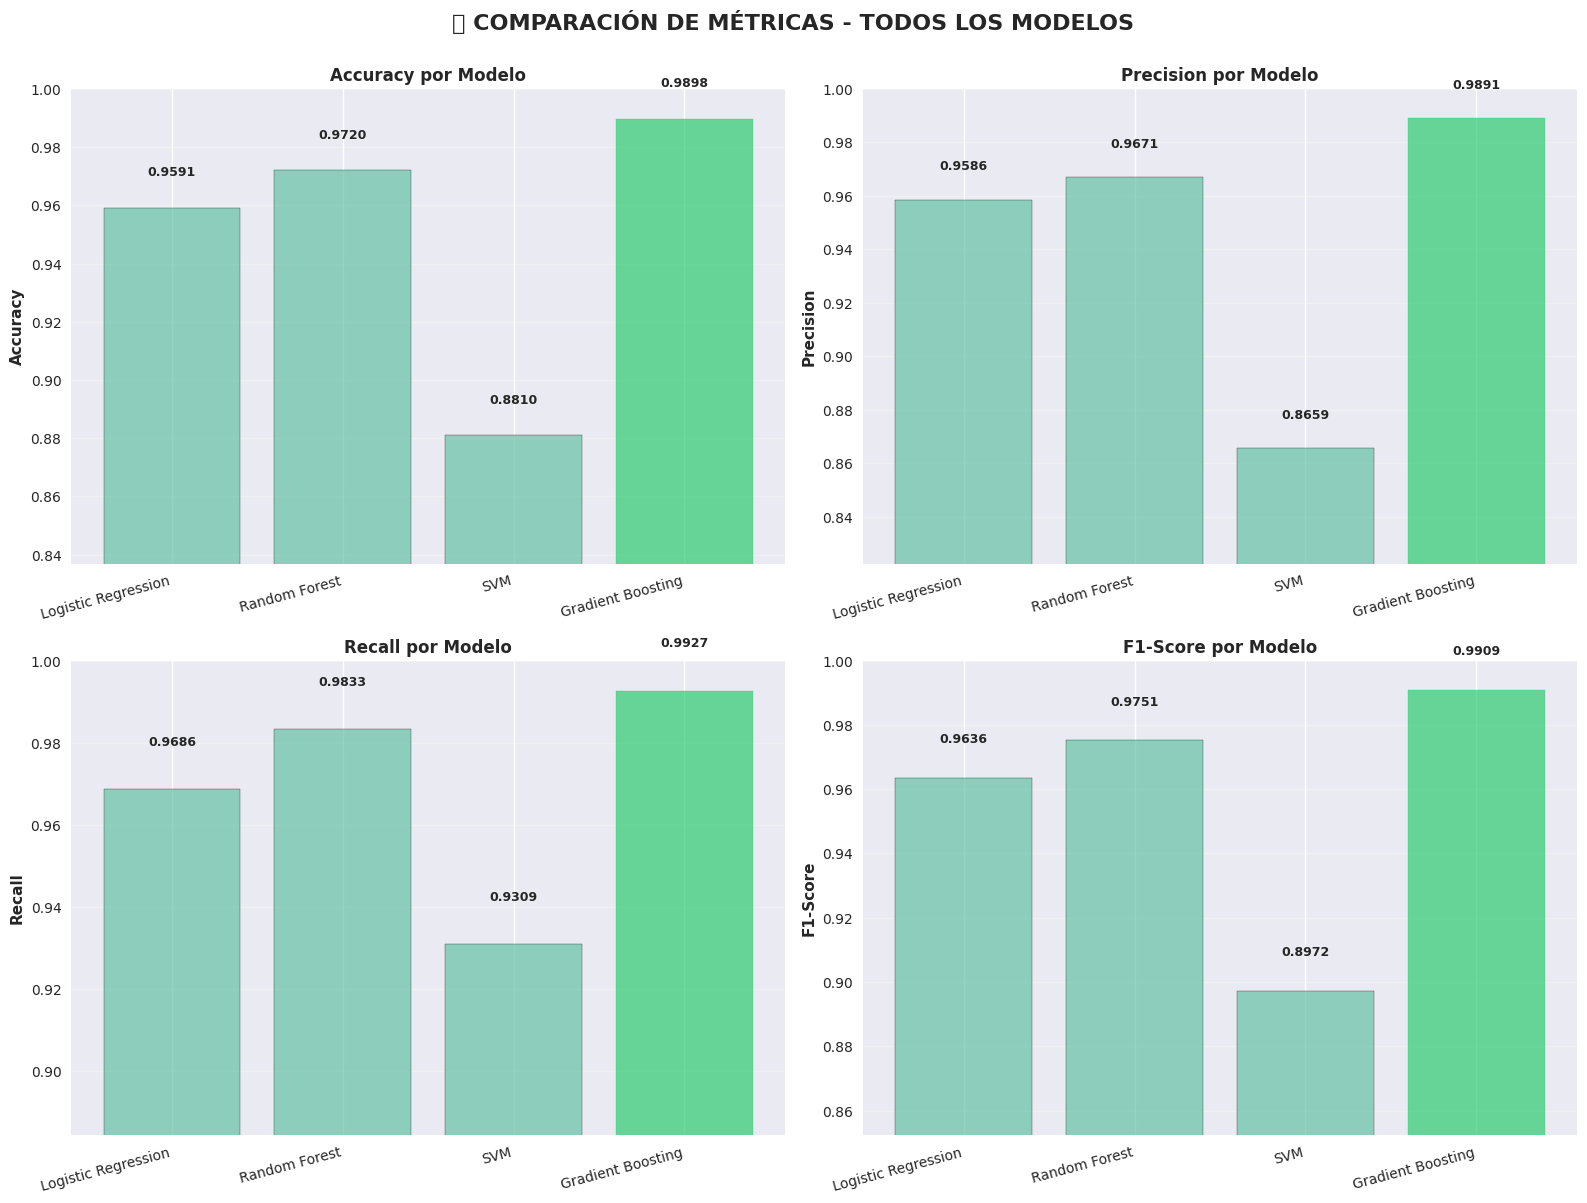

In [11]:
# Gráfico de comparación de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 COMPARACIÓN DE MÉTRICAS - TODOS LOS MODELOS', fontsize=16, fontweight='bold', y=1.00)

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, metric_name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx // 2, idx % 2]

    model_names = list(models_results.keys())
    values = [models_results[name]['metrics'][metric] for name in model_names]

    bars = ax.bar(model_names, values, alpha=0.7, edgecolor='black')

    # Colorear barra del mejor modelo
    best_idx = values.index(max(values))
    bars[best_idx].set_color('#2ecc71')

    ax.set_ylabel(metric_name, fontweight='bold')
    ax.set_title(f'{metric_name} por Modelo', fontweight='bold')
    ax.set_ylim([min(values) * 0.95, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(model_names, rotation=15, ha='right')

    # Añadir valores sobre las barras
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

---
## 🏆 **FASE 6: Selección del Mejor Modelo**

In [12]:
# Seleccionar mejor modelo basado en F1-Score
primary_metric = config['evaluation']['primary_metric']
best_model_name, best_model, best_metrics = select_best_model(models_results, metric=primary_metric)

print("\n🎯 Métricas del mejor modelo:")
for metric, value in best_metrics.items():
    if metric != 'confusion_matrix':
        if isinstance(value, float):
            print(f"   {metric}: {value:.4f}")
        else:
            print(f"   {metric}: {value}")


🏆 MEJOR MODELO: Gradient Boosting
🎯 F1_SCORE: 0.9909

🎯 Métricas del mejor modelo:
   accuracy: 0.9898
   precision: 0.9891
   recall: 0.9927
   f1_score: 0.9909
   roc_auc: 0.9990


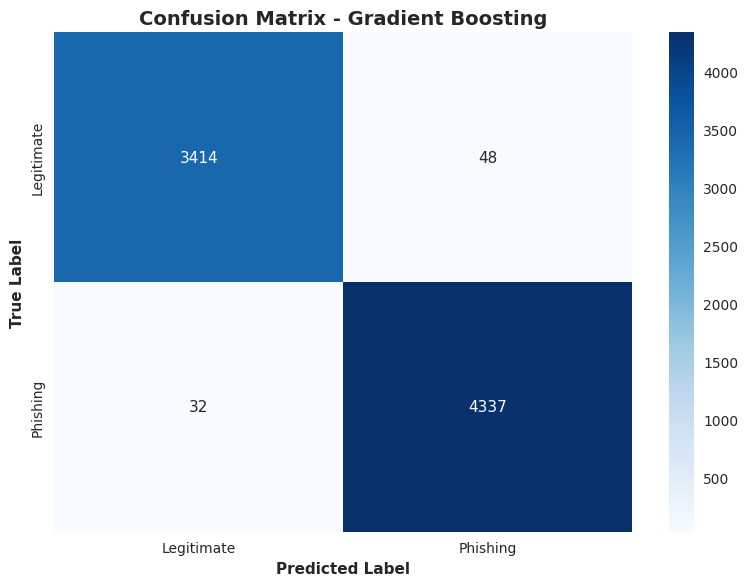


📊 Desglose de la Matriz de Confusión:
   True Negatives (TN):  3,414 - Legítimos correctamente clasificados
   False Positives (FP): 48 - Legítimos marcados como phishing
   False Negatives (FN): 32 - Phishing marcados como legítimos
   True Positives (TP):  4,337 - Phishing correctamente clasificados


In [13]:
# Mostrar matriz de confusión del mejor modelo
from sklearn.metrics import confusion_matrix

best_predictions = models_results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calcular métricas por clase
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Desglose de la Matriz de Confusión:")
print(f"   True Negatives (TN):  {tn:,} - Legítimos correctamente clasificados")
print(f"   False Positives (FP): {fp:,} - Legítimos marcados como phishing")
print(f"   False Negatives (FN): {fn:,} - Phishing marcados como legítimos")
print(f"   True Positives (TP):  {tp:,} - Phishing correctamente clasificados")

---
## 💾 **FASE 7: Guardar Resultados**

In [14]:
# Guardar todos los modelos, métricas y visualizaciones
output_dir = '../outputs'

model_info = save_results(
    models_results,
    best_model_name,
    output_dir,
    X_train,
    y_test
)

print("\n✅ Todos los resultados guardados exitosamente!")
print(f"   Directorio: {output_dir}")


💾 Guardando resultados en: ../outputs
✅ Mejor modelo guardado: ../outputs/models/best_model.pkl
✅ Metadata guardada: ../outputs/models/model_info.json
✅ Matrices de confusión guardadas en: ../outputs/reports
✅ Curvas ROC guardadas: ../outputs/reports/roc_curves_comparison.png
✅ Reporte comparativo guardado: ../outputs/reports/models_comparison_report.txt

✅ Todos los resultados guardados exitosamente!
   Directorio: ../outputs


In [15]:
# Mostrar información del modelo guardado
import json

print("📋 Información del modelo guardado:")
print(json.dumps(model_info, indent=2))

📋 Información del modelo guardado:
{
  "timestamp": "2026-01-10T15:18:46.042761",
  "best_model": "Gradient Boosting",
  "best_metrics": {
    "accuracy": 0.9897841910356276,
    "precision": 0.9890535917901938,
    "recall": 0.9926756694895857,
    "f1_score": 0.9908613205391821,
    "roc_auc": 0.9990079652358755,
    "confusion_matrix": {
      "TN": 3414,
      "FP": 48,
      "FN": 32,
      "TP": 4337
    }
  },
  "n_features": 1016,
  "n_train_samples": 31323,
  "n_test_samples": 7831,
  "all_models_metrics": {
    "Logistic Regression": {
      "accuracy": 0.9591367641425106,
      "precision": 0.9585503963759909,
      "recall": 0.9686427100022889,
      "f1_score": 0.9635701275045537,
      "roc_auc": 0.9906810878968586,
      "confusion_matrix": {
        "TN": 3279,
        "FP": 183,
        "FN": 137,
        "TP": 4232
      }
    },
    "Random Forest": {
      "accuracy": 0.9720342229600306,
      "precision": 0.9671319225574065,
      "recall": 0.9832913710231174,
    

---
## 🎯 **FASE 8: Análisis de Errores (Opcional)**

In [16]:
# Analizar casos mal clasificados
best_predictions = models_results[best_model_name]['predictions']

# False Positives: Legítimos clasificados como phishing
fp_mask = (y_test == 0) & (best_predictions == 1)
false_positives = test_df[fp_mask]

print(f"❌ False Positives (Legítimos marcados como Phishing): {len(false_positives)}")
if len(false_positives) > 0:
    print("\nEjemplos de False Positives:")
    display(false_positives[['sender', 'subject']].head(10))

# False Negatives: Phishing clasificados como legítimos
fn_mask = (y_test == 1) & (best_predictions == 0)
false_negatives = test_df[fn_mask]

print(f"\n❌ False Negatives (Phishing marcados como Legítimos): {len(false_negatives)}")
if len(false_negatives) > 0:
    print("\nEjemplos de False Negatives:")
    display(false_negatives[['sender', 'subject']].head(10))

❌ False Positives (Legítimos marcados como Phishing): 48

Ejemplos de False Positives:


,sender,subject
730,Caswell-Massey <upad@caswellmassey.com>,Save 20% with our President's Day Sale!
829,"""J. Pablo Fernández"" <zttzlu@pupeno.com>",[ILUG] [OT] Medic with knowledge on RSI
1023,user7@gvc.ceas-challenge.cc,dental nightmares (fwd)
1094,Derek Byrne <ighqp.xepks@knns.ie>,[ie-rant] Dreambox
1184,Karen Newcombe <newk@writebank.com>,[LH] Short interview with Eno
1395,"""Dr.Ruud"" <hfcog+qhuo@isolution.nl>",Re: BBC(Bleadperl Breaks CPAN) Today: SQL::Tra...
1572,Your Voice <ojlbwfjhk.gh@nielsen.com>,Happy Birthday from Your Voice
1611,Jonathan Nichols <jhseroge@pbp.net>,The 'believe-it' spams
1785,Sonic <fgljz@dreadserver.com>,Re: [ILUG] Aldi Laptops & Vista
1917,ztoalc@bobich.net,Would PersistentPerl Help?



❌ False Negatives (Phishing marcados como Legítimos): 32

Ejemplos de False Negatives:


,sender,subject
125,Latisha Bernard <linconsultonemet@consultone.de>,Give your partner new feelings while have a se...
655,craigslist remailer daemon <remailer_daemon@cr...,message undeliverable
802,Movie Ticket Promotion <support@theexecutiveba...,Enjoy a movie on us this summer
805,Olen Lawson <djaweugarv@blease.com>,Four slut stuff each others pussies with dildos
839,Lloyds TSB Bank plc <service@lloydstsb.com>,Lloyds TSB Bank - Online Security Measures
898,"""*SQ: Work-At-Home"" <alerts@mta-applypoint.com>",Alert: Make up to $154/day with Absolutely NO ...
1059,Hubert Bautista <pskgrantz@alltel.net>,Purchase medications with CanadianPharmacy and...
1213,Apple Product Offer <support@theexecutivebarga...,Make calls in style with an iPhone 3G
1454,Canadian Tire Store Specials <support@theexecu...,Canadian Tire Shopping Gift Confirmation
1551,Ann Gregory <stickel@sapura.com.my>,Tired of been pissed off in bed by your gf tha...


---
## ✅ **RESUMEN FINAL**

In [17]:
print("="*70)
print("🎉 ENTRENAMIENTO COMPLETADO EXITOSAMENTE")
print("="*70)
print(f"\n📊 Modelos entrenados: {len(models_results)}")
print(f"🏆 Mejor modelo: {best_model_name}")
print(f"🎯 F1-Score: {best_metrics['f1_score']:.4f}")
print(f"📈 Accuracy: {best_metrics['accuracy']:.4f}")
print(f"📉 Precision: {best_metrics['precision']:.4f}")
print(f"📊 Recall: {best_metrics['recall']:.4f}")
print(f"\n💾 Archivos guardados en: {output_dir}")
print(f"   - Modelos: {output_dir}/models/")
print(f"   - Reportes: {output_dir}/reports/")
print(f"   - Features: {output_dir}/features/")
print("\n✅ El modelo está listo para ser usado en producción!")
print("="*70)

🎉 ENTRENAMIENTO COMPLETADO EXITOSAMENTE

📊 Modelos entrenados: 4
🏆 Mejor modelo: Gradient Boosting
🎯 F1-Score: 0.9909
📈 Accuracy: 0.9898
📉 Precision: 0.9891
📊 Recall: 0.9927

💾 Archivos guardados en: ../outputs
   - Modelos: ../outputs/models/
   - Reportes: ../outputs/reports/
   - Features: ../outputs/features/

✅ El modelo está listo para ser usado en producción!
